# House Prices: Advanced Regression Techniques 

## Machine Learning - Assignement I - Andrea Blasioli & Kamal Nandon

# Data Understanding 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
#data_dir="C:\\Users\\Andrea Blasioli\\Desktop\\MBD\\Term II\\Machine Learning II\\Assignement I\\"

In [3]:
# Do some configuration for plotting
# Do some configurations for plot
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
def calc_rmse(y_real, y_hat):
    rmse = np.sqrt(mean_squared_error(y_real, y_hat))
    return rmse

In [5]:
def load_train_and_test_data():
    os.chdir(data_dir)
    df_train = pd.read_csv("train.csv")
    df_test = pd.read_csv("test.csv")
    return df_train,df_test

In [6]:
def label_encode(df, encoded_df, column, fill_na=None):
    le = LabelEncoder()
    encoded_df[column] = df[column]
    if fill_na is not None:
        encoded_df[column].fillna(fill_na, inplace=True)
    le.fit(encoded_df[column].unique())
    encoded_df[column] = le.transform(encoded_df[column])
    return encoded_df

In [7]:
def group_lot_frontage_by_neighborhood(train_data):
    lot_frontage_by_neighborhood = train_data["LotFrontage"].groupby(train_data["Neighborhood"])
    return lot_frontage_by_neighborhood

In [8]:
def print_correlation_of_train_vars(train_data):
    numeric_features = train_data.select_dtypes(include=[np.number])
    numeric_features.dtypes
    
    # Here we check the correlation between the different numerical values and print the top most/least correlated
    corr = numeric_features.corr()
    print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n')
    print (corr['SalePrice'].sort_values(ascending=False)[-15:])

# Data Cleaning & Data Preparation

In [9]:
def check_outliers_in_train_data(train_data):
    # Check GrLivArea Vs SalePrice
    sns.jointplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], kind='reg')
    # Check GrLivArea Vs SalePrice
    sns.jointplot(x=train_data['GrLivArea'], y=train_data['SalePrice'], kind='reg')
    
    # GarageCars Vs SalePrice
    sns.boxplot(x=train_data['GarageCars'], y=train_data['SalePrice'])
    
    # Garage Area vs Sale Price
    sns.jointplot(x=train_data['GarageArea'], y=train_data['SalePrice'], kind='reg')
    
    # Basement Area vs Sale Price
    sns.jointplot(x=train_data['TotalBsmtSF'], y=train_data['SalePrice'], kind='reg')
    
    # First Floor Area vs Sale Price
    sns.jointplot(x=train_data['1stFlrSF'], y=train_data['SalePrice'], kind='reg')
    
    # Total Rooms vs Sale Price
    sns.boxplot(x=train_data['TotRmsAbvGrd'], y=train_data['SalePrice'])
    
    # YearBuilt vs Sale Price    # See if the rmse improves
    var = 'YearBuilt'
    yr_sp = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=var, y="SalePrice", data=yr_sp)
    fig.axis(ymin=0, ymax=800000);
    plt.xticks(rotation=90);

In [10]:
# Looking at the graph of various most-correlated vars remove the outliers
def remove_outliers_from_train(train_data):
    # In the plot we see that tehre  the two datapoints in the bottom-right of the plot.
    # We need to remove these outliers manually
    train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) 
                                            & (train_data['SalePrice']<300000)].index).reset_index(drop=True)
    
    # Removing outliers manually (More than 4-cars, less than $300k; this is too unusual, if we look at the data)
    train_data = train_data.drop(train_data[(train_data['GarageCars']>3) & 
                                  (train_data['SalePrice']<300000)].index).reset_index(drop=True)
    
    # Removing outliers manually (More than 1000 sqft, less than $300k)
    train_data = train_data.drop(train_data[(train_data['GarageArea']>1000) 
                         & (train_data['SalePrice']<300000)].index).reset_index(drop=True)
    
    
    # Remove some other outliers manually - after doing some analysis
    # Removing outliers manually with LotFrontage >199
    train_data = train_data.drop(train_data[(train_data['LotFrontage'] >199)].index).reset_index(drop=True)
    # Removing outliers manually with GrLivArea >4000
    train_data = train_data.drop(train_data[(train_data['GrLivArea'] >4000)].index).reset_index(drop=True)
    # Removing outliers manually with LotArea >100000
    train_data = train_data.drop(train_data[(train_data['LotArea'] >100000)].index).reset_index(drop=True)
    
    return train_data    

In [11]:
def cleanup_numerical_columns(df, neighbourhood_lot_frontage):
    new_df = pd.DataFrame(index = df.index) # Keep the index same
        
    new_df["LotFrontage"] = df["LotFrontage"]   
    
    for key, group in neighbourhood_lot_frontage:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        new_df.loc[idx, "LotFrontage"] = group.median()    

    new_df["LotArea"] = df["LotArea"]

    new_df["MasVnrArea"] = df["MasVnrArea"]
    new_df["MasVnrArea"].fillna(0, inplace=True)
   
    new_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    new_df["BsmtFinSF1"].fillna(0, inplace=True)

    new_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    new_df["BsmtFinSF2"].fillna(0, inplace=True)

    new_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    new_df["BsmtUnfSF"].fillna(0, inplace=True)

    new_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    new_df["TotalBsmtSF"].fillna(0, inplace=True)

    new_df["1stFlrSF"] = df["1stFlrSF"]
    new_df["2ndFlrSF"] = df["2ndFlrSF"]
    new_df["GrLivArea"] = df["GrLivArea"]
    
    new_df["GarageArea"] = df["GarageArea"]
    new_df["GarageArea"].fillna(0, inplace=True)

    new_df["WoodDeckSF"] = df["WoodDeckSF"]
    new_df["OpenPorchSF"] = df["OpenPorchSF"]
    new_df["EnclosedPorch"] = df["EnclosedPorch"]
    new_df["3SsnPorch"] = df["3SsnPorch"]
    new_df["ScreenPorch"] = df["ScreenPorch"]
    
    new_df["BsmtFullBath"] = df["BsmtFullBath"]
    new_df["BsmtFullBath"].fillna(0, inplace=True)

    new_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    new_df["BsmtHalfBath"].fillna(0, inplace=True)

    new_df["FullBath"] = df["FullBath"] 
    new_df["HalfBath"] = df["HalfBath"] 
    new_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    new_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    new_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    new_df["Fireplaces"] = df["Fireplaces"] 

    new_df["GarageCars"] = df["GarageCars"]
    new_df["GarageCars"].fillna(0, inplace=True)

    new_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    new_df["OverallQual"] = df["OverallQual"]
    new_df["OverallCond"] = df["OverallCond"]

    # Convert levels such as Excellent,V. Good, Good, Etc to nos.
    # because Linear regression works on nos. And in these cases
    # We can use different nos such as 5 for ex, 5 for V.Good, 
    # and so on; following have 6 different levels
    lev_map = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    new_df["ExterQual"] = df["ExterQual"].map(lev_map).astype(int)
    new_df["ExterCond"] = df["ExterCond"].map(lev_map).astype(int)
    new_df["BsmtQual"] = df["BsmtQual"].map(lev_map).astype(int)
    new_df["BsmtCond"] = df["BsmtCond"].map(lev_map).astype(int)
    new_df["HeatingQC"] = df["HeatingQC"].map(lev_map).astype(int)
    new_df["KitchenQual"] = df["KitchenQual"].map(lev_map).astype(int)
    new_df["FireplaceQu"] = df["FireplaceQu"].map(lev_map).astype(int)
    new_df["GarageQual"] = df["GarageQual"].map(lev_map).astype(int)
    new_df["GarageCond"] = df["GarageCond"].map(lev_map).astype(int)
    new_df["PoolQC"] = df["PoolQC"].map(lev_map).astype(int)

    # following have five different levels
    lev_map = {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
    new_df["BsmtExposure"] = df["BsmtExposure"].map(lev_map).astype(int)

    # following have 7 different levels
    lev_map = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    new_df["BsmtFinType1"] = df["BsmtFinType1"].map(lev_map).astype(int)
    new_df["BsmtFinType2"] = df["BsmtFinType2"].map(lev_map).astype(int)

    # Nine diff levels 
    lev_map = {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
    new_df["Functional"] = df["Functional"].map(lev_map).astype(int)

    # 4 levels
    lev_map = {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}
    new_df["GarageFinish"] = df["GarageFinish"].map(lev_map).astype(int)

    # 5 diff levels
    lev_map = {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}
    new_df["Fence"] = df["Fence"].map(lev_map).astype(int)

    new_df["YearBuilt"] = df["YearBuilt"]
    new_df["YearRemodAdd"] = df["YearRemodAdd"]

    new_df["GarageYrBlt"] = df["GarageYrBlt"]
    new_df["GarageYrBlt"].fillna(0.0, inplace=True)

    new_df["MoSold"] = df["MoSold"]
    new_df["YrSold"] = df["YrSold"]
    
    new_df["LowQualFinSF"] = df["LowQualFinSF"]
    new_df["MiscVal"] = df["MiscVal"]    

    new_df["PoolArea"] = df["PoolArea"]
    # If there is na means 0 pool area
    new_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    new_df = label_encode(df, new_df, "MSSubClass")
    new_df = label_encode(df, new_df, "MSZoning", "RL")
    new_df = label_encode(df, new_df, "LotConfig")
    new_df = label_encode(df, new_df, "Neighborhood")
    new_df = label_encode(df, new_df, "Condition1")
    new_df = label_encode(df, new_df, "BldgType")
    new_df = label_encode(df, new_df, "HouseStyle")
    new_df = label_encode(df, new_df, "RoofStyle")
    new_df = label_encode(df, new_df, "Exterior1st", "Other")
    new_df = label_encode(df, new_df, "Exterior2nd", "Other")
    new_df = label_encode(df, new_df, "MasVnrType", "None")
    new_df = label_encode(df, new_df, "Foundation")
    new_df = label_encode(df, new_df, "SaleType", "Oth")
    new_df = label_encode(df, new_df, "SaleCondition")

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    new_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    new_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    new_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    new_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    new_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    new_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    new_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    new_df["Remodeled"] = (new_df["YearRemodAdd"] != new_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    new_df["RecentRemodel"] = (new_df["YearRemodAdd"] == new_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    new_df["VeryNewHouse"] = (new_df["YearBuilt"] == new_df["YrSold"]) * 1

    new_df["Has2ndFloor"] = (new_df["2ndFlrSF"] == 0) * 1
    new_df["HasMasVnr"] = (new_df["MasVnrArea"] == 0) * 1
    new_df["HasWoodDeck"] = (new_df["WoodDeckSF"] == 0) * 1
    new_df["HasOpenPorch"] = (new_df["OpenPorchSF"] == 0) * 1
    new_df["HasEnclosedPorch"] = (new_df["EnclosedPorch"] == 0) * 1
    new_df["Has3SsnPorch"] = (new_df["3SsnPorch"] == 0) * 1
    new_df["HasScreenPorch"] = (new_df["ScreenPorch"] == 0) * 1


    # Months with the largest number of deals may be significant.
    new_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    new_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    new_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    new_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    new_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    new_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    new_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    new_df["Neighborhood_Good"].fillna(0, inplace=True)

    new_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    new_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    new_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    new_df["TotalArea"] = new_df[area_cols].sum(axis=1)

    new_df["TotalArea1st2nd"] = new_df["1stFlrSF"] + new_df["2ndFlrSF"]

    new_df["Age"] = 2010 - new_df["YearBuilt"]
    new_df["TimeSinceSold"] = 2010 - new_df["YrSold"]

    new_df["SeasonSold"] = new_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    new_df["YearsSinceRemodel"] = new_df["YrSold"] - new_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    new_df["SimplOverallQual"] = new_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    new_df["SimplOverallCond"] = new_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    new_df["SimplPoolQC"] = new_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    new_df["SimplGarageCond"] = new_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplGarageQual"] = new_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplFireplaceQu"] = new_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplFireplaceQu"] = new_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplFunctional"] = new_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    new_df["SimplKitchenQual"] = new_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplHeatingQC"] = new_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplBsmtFinType1"] = new_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    new_df["SimplBsmtFinType2"] = new_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    new_df["SimplBsmtCond"] = new_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplBsmtQual"] = new_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplExterCond"] = new_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    new_df["SimplExterQual"] = new_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    new_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return new_df

In [12]:
# Load train and test data
df_train, df_test = load_train_and_test_data()

# There are a few houses with more than 4000 sq ft living area that are
# outliers, so we drop them from the training data.
#df_train.drop(df_train[df_train["GrLivArea"] > 4000].index, inplace=True)



In [13]:
print_correlation_of_train_vars(df_train)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 

BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


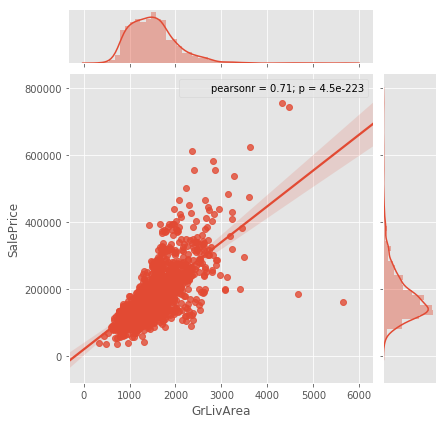

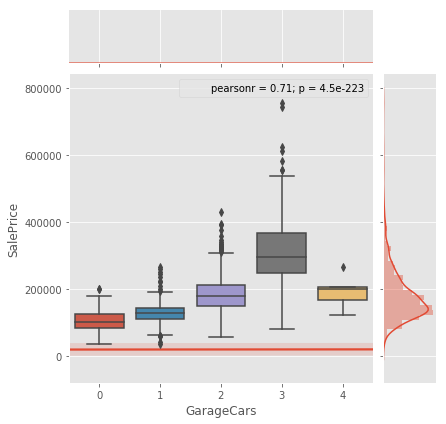

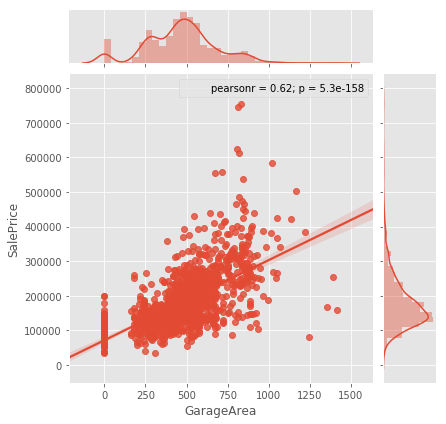

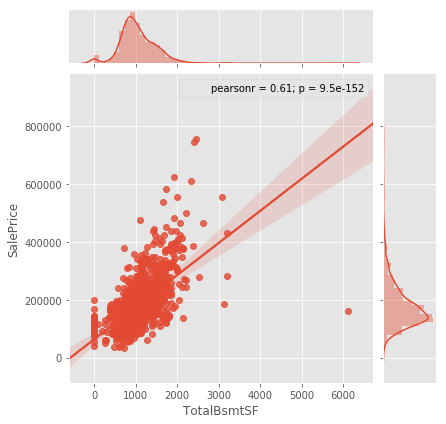

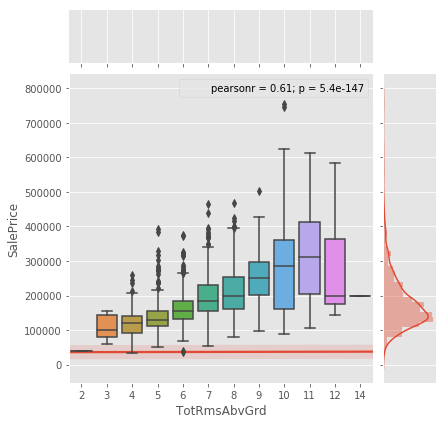

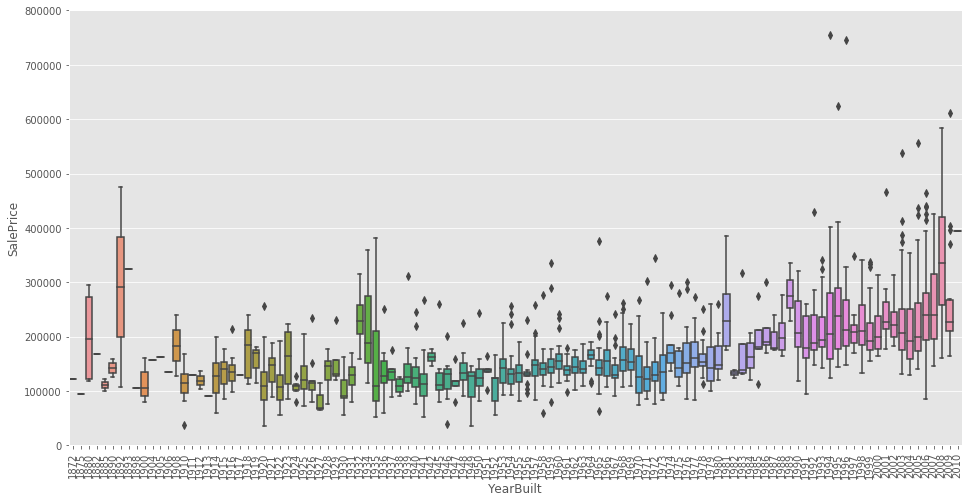

In [14]:
check_outliers_in_train_data(df_train)

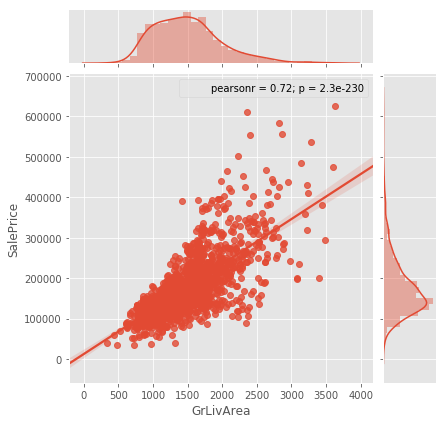

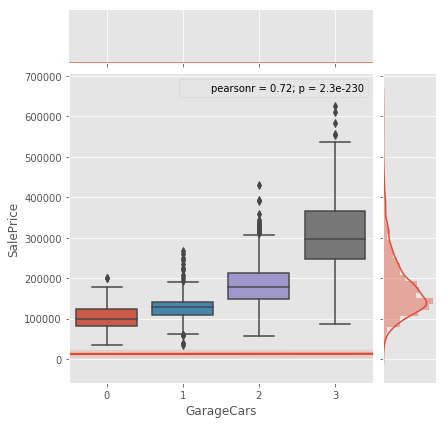

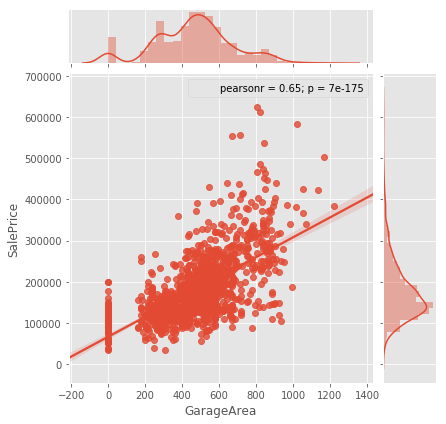

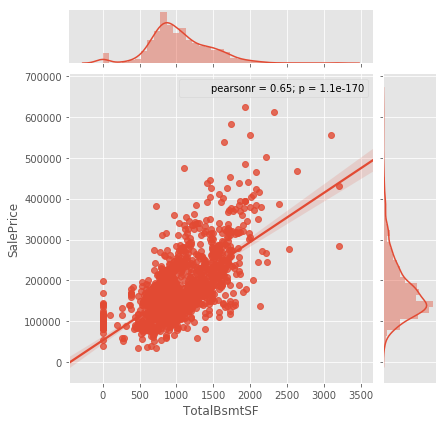

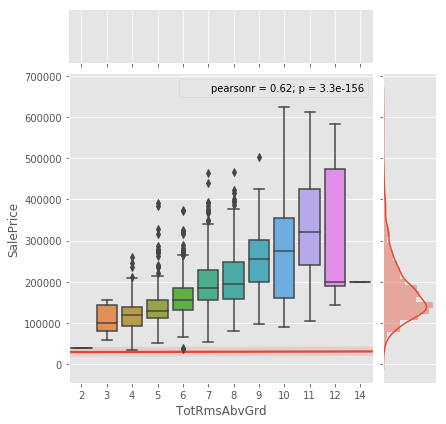

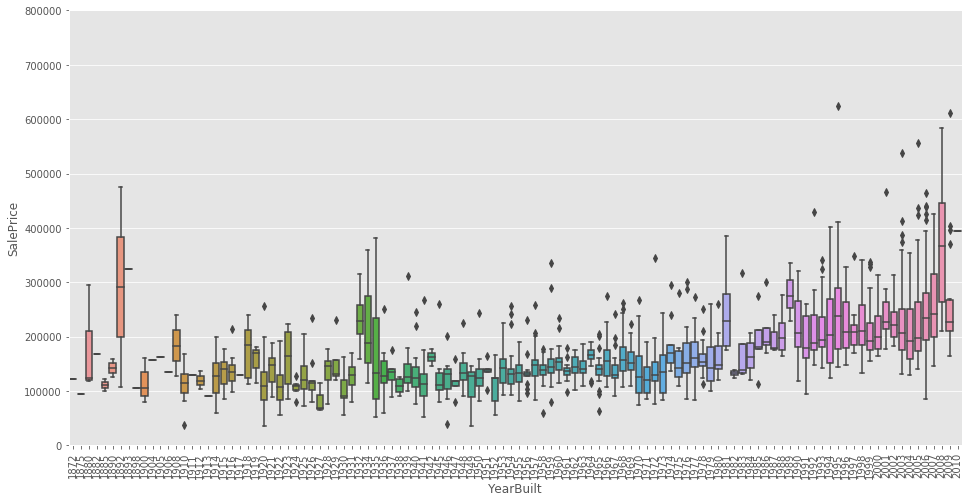

In [15]:
df_train = remove_outliers_from_train(df_train)
# Once again check if the outliers have been removed and things look better
check_outliers_in_train_data(df_train)

In [16]:
neighbourhood_lot_frontage = group_lot_frontage_by_neighborhood(df_train)

In [17]:
df_train_cleaned = cleanup_numerical_columns(df_train, neighbourhood_lot_frontage)
df_test_cleaned = cleanup_numerical_columns(df_test, neighbourhood_lot_frontage)

In [18]:
print(df_train_cleaned.shape)
print(df_test_cleaned.shape)

(1441, 111)
(1459, 111)


In [19]:
# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = df_train.index)
neighborhood_bin_train["NeighborhoodBin"] = df_train_cleaned["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = df_test.index)
neighborhood_bin_test["NeighborhoodBin"] = df_test_cleaned["NeighborhoodBin"]

In [20]:
numeric_features = df_train_cleaned.dtypes[df_train_cleaned.dtypes != "object"].index

In [21]:
# Convert categorical features using one-hot encoding.
def onehot_encode(onehot_encoded_df, df, column_name, fill_na, drop_name):
    onehot_encoded_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_encoded_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_encoded_df[column_name], prefix="_" + column_name)
    
    onehot_encoded_df = onehot_encoded_df.join(dummies)
    onehot_encoded_df = onehot_encoded_df.drop([column_name], axis=1)
    return onehot_encoded_df

In [22]:
def cleanup_onehot_encoded_df(df):
    onehot_encoded_df = pd.DataFrame(index = df.index)

    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "MSSubClass", None, "40")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "MSZoning", "RL", "RH")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "LotConfig", None, "FR3")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Neighborhood", None, "OldTown")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Condition1", None, "RRNe")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BldgType", None, "2fmCon")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "HouseStyle", None, "1.5Unf")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "RoofStyle", None, "Shed")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Foundation", None, "Wood")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "SaleType", "WD", "Oth")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_encoded_df = onehot_encode(onehot_encoded_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # add the booleans from calc_df as dummy variables.
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "LotShape", None, "IR3")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "LandContour", None, "Low")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "LandSlope", None, "Sev")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "GarageType", "None", "CarPort")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "PavedDrive", None, "P")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "MiscFeature", "None", "Othr")

    # gnoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Street", None, "Grvl")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Alley", "None", "Grvl")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Condition2", None, "PosA")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "RoofMatl", None, "WdShake")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Heating", None, "Wall")

    # One hot encode the following numerical variables.
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "ExterQual", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "ExterCond", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BsmtQual", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BsmtCond", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "HeatingQC", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "KitchenQual", "TA", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "FireplaceQu", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "GarageQual", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "GarageCond", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "PoolQC", "None", "Ex")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BsmtExposure", "None", "Gd")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Functional", "Typ", "Typ")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "GarageFinish", "None", "Fin")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "Fence", "None", "MnPrv")
    onehot_encoded_df = onehot_encode(onehot_encoded_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_encoded_df = onehot_encode(onehot_encoded_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_encoded_df = onehot_encode(onehot_encoded_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_encoded_df = onehot_encode(onehot_encoded_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_encoded_df

In [23]:
# Add the one-hot encoded categorical features.
onehot_encoded_df = cleanup_onehot_encoded_df(df_train)
onehot_encoded_df = onehot_encode(onehot_encoded_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
df_train_cleaned = df_train_cleaned.join(onehot_encoded_df)

In [24]:
# These onehot columns are missing in the test data, so drop them from the
# training data too to simplify the model
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
df_train_cleaned.drop(drop_cols, axis=1, inplace=True)

onehot_encoded_df = cleanup_onehot_encoded_df(df_test)
onehot_encoded_df = onehot_encode(onehot_encoded_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
df_test_cleaned = df_test_cleaned.join(onehot_encoded_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
df_test_cleaned.drop(["_MSSubClass_150"], axis=1, inplace=True)

In [25]:
# We take the log here ; also we will we need to 
# transform the prediction back(exp) to to get an actual sale price.
label_df = pd.DataFrame(index = df_train_cleaned.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(df_train["SalePrice"])

print("Training set size:", df_train_cleaned.shape)
print("Test set size:", df_test_cleaned.shape)

################################################################################

Training set size: (1441, 406)
Test set size: (1459, 406)


## Regression Modeling

In [26]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0005, max_iter=100000)
model.fit(df_train_cleaned, label_df)

# Run prediction on training set
y_hat = model.predict(df_train_cleaned)
y_test = label_df
print("Lasso score on training set: ", calc_rmse(y_test, y_hat))

# Run prediction on the Kaggle test set.
y_hat_lasso = model.predict(df_test_cleaned)

Lasso score on training set:  0.097254753862


C:\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [27]:
# Blend the results of the two regressors and save the prediction to a CSV file.
y_hat = np.exp(y_hat_lasso)

df_pred = pd.DataFrame(y_hat, index=df_test["Id"], columns=["SalePrice"])
df_pred.to_csv('kaggle_submission.csv', header=True, index_label='Id')